In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multi-label-text-classification-datasets/reuters21578.csv
/kaggle/input/multi-label-text-classification-datasets/MN-DS-news.csv


In [2]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings('ignore')

In [3]:
reuters_path = "/kaggle/input/multi-label-text-classification-datasets/reuters21578.csv"
df_reuters = pd.read_csv(reuters_path)

mn_path = "/kaggle/input/multi-label-text-classification-datasets/MN-DS-news.csv"
df_mn = pd.read_csv(mn_path)

In [4]:
df_reuters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19043 entries, 0 to 19042
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   newid           0 non-null      float64
 1   oldid           0 non-null      float64
 2   topics          0 non-null      float64
 3   lewissplit      0 non-null      float64
 4   cgisplit        0 non-null      float64
 5   date            19043 non-null  object 
 6   title           19043 non-null  object 
 7   dateline        19043 non-null  object 
 8   body            19043 non-null  object 
 9   topics_list     10377 non-null  object 
 10  places_list     18398 non-null  object 
 11  people_list     1012 non-null   object 
 12  orgs_list       854 non-null    object 
 13  exchanges_list  402 non-null    object 
 14  companies_list  0 non-null      float64
 15  num_topics      19043 non-null  int64  
 16  num_places      19043 non-null  int64  
 17  num_people      19043 non-null 

In [5]:
df_mn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10917 entries, 0 to 10916
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   data_id           10917 non-null  int64 
 1   id                10917 non-null  object
 2   date              10917 non-null  object
 3   source            10917 non-null  object
 4   title             10917 non-null  object
 5   content           10917 non-null  object
 6   author            7605 non-null   object
 7   url               10917 non-null  object
 8   published         10917 non-null  object
 9   published_utc     10917 non-null  int64 
 10  collection_utc    10917 non-null  int64 
 11  category_level_1  10917 non-null  object
 12  category_level_2  10917 non-null  object
dtypes: int64(3), object(10)
memory usage: 1.1+ MB


In [6]:
# Reuters: 构造 input & output
df_reuters["input"] = df_reuters["title"].fillna('') + " " + df_reuters["body"].fillna('')
df_reuters["output"] = df_reuters["topics_list"].apply(lambda x: x.split(";") if isinstance(x, str) else [])
df_reuters = df_reuters[df_reuters["output"].map(len) > 0].reset_index(drop=True)

In [7]:
(df_reuters["output"])

0                                                  [cocoa]
1               [grain, wheat, corn, barley, oat, sorghum]
2        [veg-oil, linseed, lin-oil, soy-oil, sun-oil, ...
3                                                   [earn]
4                                                    [acq]
                               ...                        
10372                                                [acq]
10373                                 [money-fx, dlr, yen]
10374                                               [ship]
10375                                                [ipi]
10376                                               [gold]
Name: output, Length: 10377, dtype: object

In [8]:
# Convert the multi-level in mn into multi-label
def expand_hierarchical(row):
    lvl1 = str(row.get("category_level_1") or "")
    lvl2 = str(row.get("category_level_2") or "")
    # 1) Split by comma and remove whitespace
    comma_parts = [p.strip() for p in lvl1.split(",") if p and p.strip()]
    if not comma_parts:
        return [f"{lvl1}_{lvl2}"] if lvl2 else [lvl1]  # 兜底
        
    # 2) The last phrase is split by "and" (only conjunction is split, not the wrong word)
    last_phrase = comma_parts[-1]
    and_tokens = [t.strip() for t in re.split(r"\band\b", last_phrase) if t.strip()]

    # 3) Main tag: "previous paragraphs" in the comma + the word before and in the last paragraph
    main_labels = comma_parts[:-1] + and_tokens[:-1]

    # 4) Subtag base word: last token
    base = and_tokens[-1] if and_tokens else last_phrase.strip()

    # 5) Combine into the expected format (de-duplicate and preserve order)
    labels = main_labels + [f"{base}_{lvl2}" if lvl2 else base]
    # Remove duplicates and keep order
    seen, result = set(), []
    for x in labels:
        if x not in seen and x != "":
            seen.add(x)
            result.append(x)
    return result

In [9]:
df_mn["output"] = df_mn.apply(lambda row: [f"{row['category_level_1']}_{row['category_level_2']}"], axis=1)
df_mn["input"]  = df_mn["title"].fillna('') + " " + df_mn["content"].fillna('')
df_mn = df_mn[df_mn["output"].map(len) > 0].reset_index(drop=True)
df_mn["output"] = df_mn.apply(expand_hierarchical, axis=1)


In [10]:
(df_mn["output"])

0                           [crime, law, justice_crime]
1                           [crime, law, justice_crime]
2                           [crime, law, justice_crime]
3                           [crime, law, justice_crime]
4                           [crime, law, justice_crime]
                              ...                      
10912    [conflict, war, peace_post-war reconstruction]
10913    [conflict, war, peace_post-war reconstruction]
10914    [conflict, war, peace_post-war reconstruction]
10915    [conflict, war, peace_post-war reconstruction]
10916    [conflict, war, peace_post-war reconstruction]
Name: output, Length: 10917, dtype: object

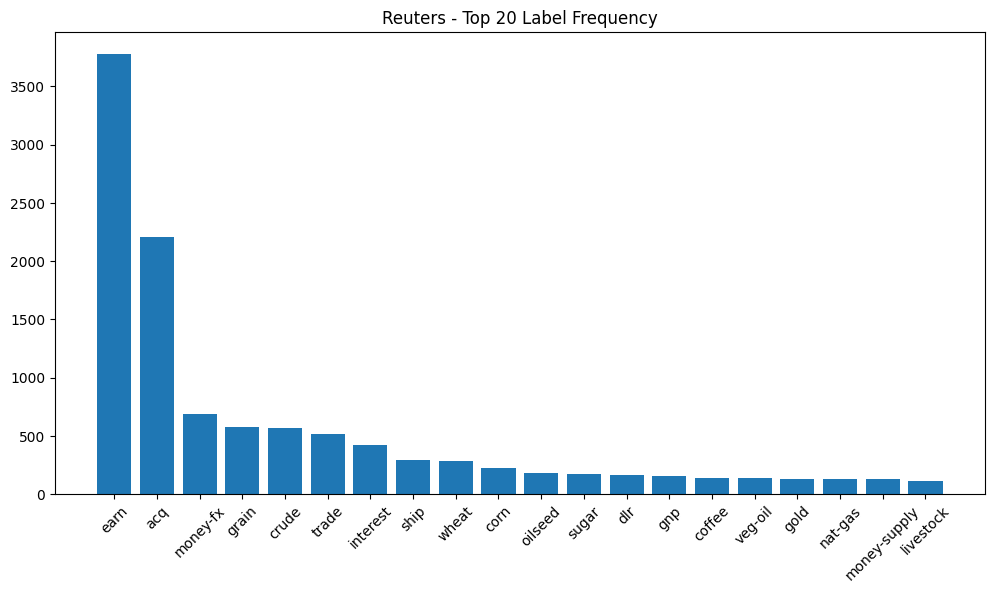

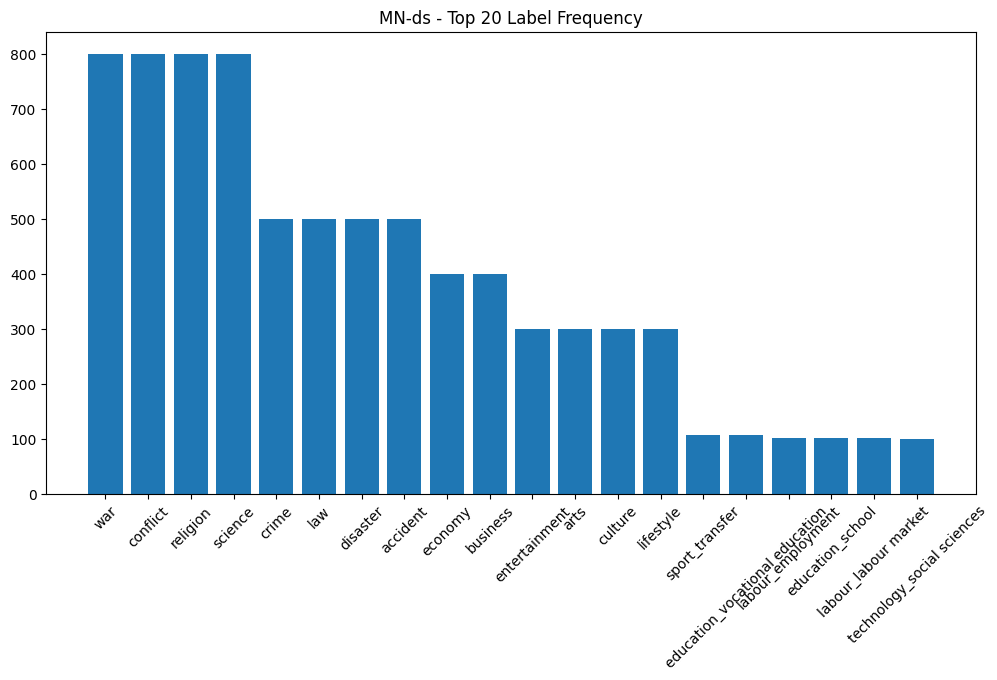

In [11]:
# 标签分布可视化函数
def plot_label_distribution(df, title):
    all_labels = [l for labels in df["output"] for l in labels]
    label_counts = Counter(all_labels)
    label_df = pd.DataFrame(label_counts.items(), columns=["Label", "Count"]).sort_values(by="Count", ascending=False)
    plt.figure(figsize=(12,6))
    plt.bar(label_df["Label"][:20], label_df["Count"][:20])
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

plot_label_distribution(df_reuters, "Reuters - Top 20 Label Frequency")
plot_label_distribution(df_mn, "MN-ds - Top 20 Label Frequency")